## Deep SARSA in Cartpole using Keras-RL.
#### This is a step-by-step guide to using a neural network-based SARSA in Cartpole, a simple OpenAI gym environment.


### Table of Contents

#### [Setup and Keras-RL](#Setup_and_Environment)
- in this section, we import all the necessary libraries and do a minor modification to the Keras-RL Sarsa agent;

#### [Deep SARSA](#Sarsa)
- in this section, we use Deep SARSA to solve the Cartpole problem.



## Setup and Keras-RL <a name='Setup_and_Environment'></a>

In [0]:
# pip install keras-rl

In [2]:
import numpy as np
import gym
# %tensorflow_version 1.14
from keras.layers import Dense, Flatten, Activation
from keras.models import Sequential
from keras.optimizers import Adam

from rl.agents import SARSAAgent
from rl.policy import EpsGreedyQPolicy
from rl.callbacks import TrainEpisodeLogger

Using TensorFlow backend.
/Users/gelanatostaeva/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/gelanatostaeva/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/gelanatostaeva/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/gelanatostaeva/anacond

The code below is from [Keras-RL](https://github.com/keras-rl/keras-rl/blob/master/rl/agents/sarsa.py#L17) with a minor modification to get the probabilities vector (which we need for the Ensemble learning part as explained at the end of the associated Medium post).

*Note that we are importing some libraries again; some versions of tensorflow are not compatible with parts of this implementation, and importing twice seemed to fix it.*

In [76]:
import collections

from keras.callbacks import History
from keras.models import Model
from keras.layers import Input, Lambda
import keras.backend as K

from rl.core import Agent
from rl.agents.dqn import mean_q
from rl.util import huber_loss
from rl.policy import EpsGreedyQPolicy, GreedyQPolicy
from rl.util import get_object_config


class SARSAAgent(Agent):
    """This class defines the SARSA agent
    """
    def __init__(self, model, nb_actions, policy, test_policy=EpsGreedyQPolicy(), gamma=.9, nb_steps_warmup=10,
                 train_interval=1, delta_clip=np.inf, *args, **kwargs):
        super(SarsaAgent, self).__init__(*args, **kwargs)

        if policy is None:
            policy = EpsGreedyQPolicy()
        if test_policy is None:
            test_policy = GreedyQPolicy()

        self.model = model
        self.nb_actions = nb_actions
        self.policy = policy
        self.test_policy = test_policy
        self.gamma = gamma
        self.nb_steps_warmup = nb_steps_warmup
        self.train_interval = train_interval

        self.delta_clip = delta_clip
        self.compiled = False
        self.actions = None
        self.observations = None
        self.rewards = None
        self.q_values=[]

    def compute_batch_q_values(self, state_batch):
        batch = self.process_state_batch(state_batch)
        q_values = self.model.predict_on_batch(batch)
        assert q_values.shape == (len(state_batch), self.nb_actions)
        return q_values

    def compute_q_values(self, state):
        q_values = self.compute_batch_q_values([state]).flatten()
        assert q_values.shape == (self.nb_actions,)
        return q_values

    def process_state_batch(self, batch):
        batch = np.array(batch)
        if self.processor is None:
            return batch
        return self.processor.process_state_batch(batch)

    def get_config(self):
        config = super(SarsaAgent, self).get_config()
        config['nb_actions'] = self.nb_actions
        config['gamma'] = self.gamma
        config['nb_steps_warmup'] = self.nb_steps_warmup
        config['train_interval'] = self.train_interval
        config['delta_clip'] = self.delta_clip
        config['model'] = get_object_config(self.model)
        config['policy'] = get_object_config(self.policy)
        config['test_policy'] = get_object_config(self.test_policy)
        return config

    def compile(self, optimizer, metrics=[]):
        metrics += [mean_q]  

        def clipped_masked_error(args):
            y_true, y_pred, mask = args
            loss = huber_loss(y_true, y_pred, self.delta_clip)
            loss *= mask  
            return K.sum(loss, axis=-1)

        # Create trainable model. The problem is that we need to mask the output since we only
        # ever want to update the Q values for a certain action. The way we achieve this is by
        # using a custom Lambda layer that computes the loss. This gives us the necessary flexibility
        # to mask out certain parameters by passing in multiple inputs to the Lambda layer.
        y_pred = self.model.output
        y_true = Input(name='y_true', shape=(self.nb_actions,))
        mask = Input(name='mask', shape=(self.nb_actions,))
        loss_out = Lambda(clipped_masked_error, output_shape=(1,), name='loss')([y_pred, y_true, mask])
        ins = [self.model.input] if type(self.model.input) is not list else self.model.input
        trainable_model = Model(inputs=ins + [y_true, mask], outputs=[loss_out, y_pred])
        assert len(trainable_model.output_names) == 2
        combined_metrics = {trainable_model.output_names[1]: metrics}
        losses = [
            lambda y_true, y_pred: y_pred,  # loss is computed in Lambda layer
            lambda y_true, y_pred: K.zeros_like(y_pred),  # we only include this for the metrics
        ]
        trainable_model.compile(optimizer=optimizer, loss=losses, metrics=combined_metrics)
        self.trainable_model = trainable_model

        self.compiled = True

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def save_weights(self, filepath, overwrite=False):
        self.model.save_weights(filepath, overwrite=overwrite)

    def reset_states(self):
        self.actions = collections.deque(maxlen=2)
        self.observations = collections.deque(maxlen=2)
        self.rewards = collections.deque(maxlen=2)
        if self.compiled:
            self.model.reset_states()

    def forward(self, observation):
        # Select an action.
        q_values = self.compute_q_values([observation])
        if self.training:
            action = self.policy.select_action(q_values=q_values)
        else:
            action = self.test_policy.select_action(q_values=q_values)

        # Book-keeping.
        self.observations.append(observation)
        self.actions.append(action)
        # self.q_values=q_values

        return action

    def backward(self, reward, terminal):
        metrics = [np.nan for _ in self.metrics_names]
        if not self.training:
            # We're done here. No need to update the experience memory since we only use the working
            # memory to obtain the state over the most recent observations.
            return metrics

        # Train the network on a single stochastic batch.
        if self.step > self.nb_steps_warmup and self.step % self.train_interval == 0:
            # Start by extracting the necessary parameters (we use a vectorized implementation).
            self.rewards.append(reward)
            if len(self.observations) < 2:
                return metrics  # not enough data yet

            state0_batch = [self.observations[0]]
            reward_batch = [self.rewards[0]]
            action_batch = [self.actions[0]]
            terminal1_batch = [0.] if terminal else [1.]
            state1_batch = [self.observations[1]]
            action1_batch = [self.actions[1]]

            # Prepare and validate parameters.
            state0_batch = self.process_state_batch(state0_batch)
            state1_batch = self.process_state_batch(state1_batch)
            terminal1_batch = np.array(terminal1_batch)
            reward_batch = np.array(reward_batch)
            assert reward_batch.shape == (1,)
            assert terminal1_batch.shape == reward_batch.shape
            assert len(action_batch) == len(reward_batch)

            batch = self.process_state_batch(state1_batch)
            q_values = self.compute_q_values(batch)
            q_values = q_values.reshape((1, self.nb_actions))
            probs=q_values[0]
            probs/=np.sum(probs)
            self.q_values.append(probs)
            # self.q_values/=np.sum(q_values)

            q_batch = q_values[0, action1_batch]

            assert q_batch.shape == (1,)
            targets = np.zeros((1, self.nb_actions))
            dummy_targets = np.zeros((1,))
            masks = np.zeros((1, self.nb_actions))

            # Compute r_t + gamma * Q(s_t+1, a_t+1)
            discounted_reward_batch = self.gamma * q_batch
            # Set discounted reward to zero for all states that were terminal.
            discounted_reward_batch *= terminal1_batch
            assert discounted_reward_batch.shape == reward_batch.shape
            Rs = reward_batch + discounted_reward_batch
            for idx, (target, mask, R, action) in enumerate(zip(targets, masks, Rs, action_batch)):
                target[action] = R  # update action with estimated accumulated reward
                dummy_targets[idx] = R
                mask[action] = 1.  # enable loss for this specific action
            targets = np.array(targets).astype('float32')
            masks = np.array(masks).astype('float32')

            # Finally, perform a single update on the entire batch. We use a dummy target since
            # the actual loss is computed in a Lambda layer that needs more complex input. However,
            # it is still useful to know the actual target to compute metrics properly.
            state0_batch = state0_batch.reshape((1,) + state0_batch.shape)
            ins = [state0_batch] if type(self.model.input) is not list else state0_batch
            metrics = self.trainable_model.train_on_batch(ins + [targets, masks], [dummy_targets, targets])
            metrics = [metric for idx, metric in enumerate(metrics) if idx not in (1, 2)]  # throw away individual losses
            metrics += self.policy.metrics
            if self.processor is not None:
                metrics += self.processor.metrics
        return metrics

    @property
    def layers(self):
        return self.model.layers[:]

    @property
    def metrics_names(self):
        # Throw away individual losses and replace output name since this is hidden from the user.
        assert len(self.trainable_model.output_names) == 2
        dummy_output_name = self.trainable_model.output_names[1]
        model_metrics = [name for idx, name in enumerate(self.trainable_model.metrics_names) if idx not in (1, 2)]
        model_metrics = [name.replace(dummy_output_name + '_', '') for name in model_metrics]

        names = model_metrics + self.policy.metrics_names[:]
        if self.processor is not None:
            names += self.processor.metrics_names[:]
        return names

    @property
    def policy(self):
        return self.__policy

    @policy.setter
    def policy(self, policy):
        self.__policy = policy
        self.__policy._set_agent(self)

    @property
    def test_policy(self):
        return self.__test_policy

    @test_policy.setter
    def test_policy(self, policy):
        self.__test_policy = policy
        self.__test_policy._set_agent(self)

# Aliases
SarsaAgent = SARSAAgent

## Deep SARSA in Cartpole <a name='Sarsa'></a>

In [77]:
#Setting up the environment
env = gym.make('CartPole-v1')
seed_val = 456
env.seed(seed_val)
np.random.seed(seed_val)

#Getting the state and action space
states = env.observation_space.shape[0]
actions = env.action_space.n

#Defining a Neural Network function for our Cartpole agent 
def agent(states, actions):
    """Creating a simple Deep Neural Network."""
    model = Sequential()
    model.add(Flatten(input_shape = (1, states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model


In [78]:
#Getting our neural network
model = agent(states, actions)
#Defining SARSA Keras-RL agent: inputing the policy and the model
sarsa = SARSAAgent(model=model, nb_actions=actions, policy=EpsGreedyQPolicy())
#Compiling SARSA with mean squared error loss
sarsa.compile('adam', metrics=["mse"])

#Training the agent for 50000 steps
sarsa.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 21s 2ms/step - reward: 1.0000
488 episodes - episode_reward: 20.248 [8.000, 155.000] - loss: 0.013 - mse: 0.939 - mean_q: 1.436

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 20s 2ms/step - reward: 1.0000
446 episodes - episode_reward: 22.538 [8.000, 284.000] - loss: 0.004 - mse: 0.975 - mean_q: 1.444

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 21s 2ms/step - reward: 1.0000
316 episodes - episode_reward: 31.848 [8.000, 215.000] - loss: 0.003 - mse: 1.000 - mean_q: 1.445

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 21s 2ms/step - reward: 1.0000
345 episodes - episode_reward: 28.939 [8.000, 500.000] - loss: 0.003 - mse: 0.999 - mean_q: 1.444

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 22s 2ms/step - reward: 1.0000
done, took 105.404 

In [79]:
#Fitting and testing our agent model for 500 episodes
scores = sarsa.test(env, nb_episodes = 500, visualize= False)

Testing for 500 episodes ...
Episode 1: reward: 117.000, steps: 117
Episode 2: reward: 112.000, steps: 112
Episode 3: reward: 116.000, steps: 116
Episode 4: reward: 109.000, steps: 109
Episode 5: reward: 121.000, steps: 121
Episode 6: reward: 111.000, steps: 111
Episode 7: reward: 109.000, steps: 109
Episode 8: reward: 115.000, steps: 115
Episode 9: reward: 117.000, steps: 117
Episode 10: reward: 119.000, steps: 119
Episode 11: reward: 118.000, steps: 118
Episode 12: reward: 117.000, steps: 117
Episode 13: reward: 118.000, steps: 118
Episode 14: reward: 122.000, steps: 122
Episode 15: reward: 113.000, steps: 113
Episode 16: reward: 126.000, steps: 126
Episode 17: reward: 117.000, steps: 117
Episode 18: reward: 121.000, steps: 121
Episode 19: reward: 117.000, steps: 117
Episode 20: reward: 118.000, steps: 118
Episode 21: reward: 118.000, steps: 118
Episode 22: reward: 112.000, steps: 112
Episode 23: reward: 119.000, steps: 119
Episode 24: reward: 123.000, steps: 123
Episode 25: reward: 

In [74]:
#Importing the necessary plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

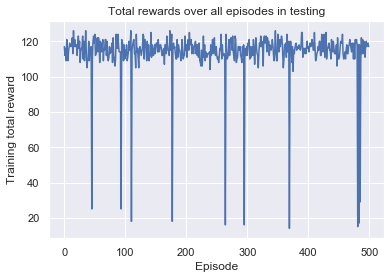

In [84]:
#Visualizing our resulted rewards
plt.plot(scores.history['episode_reward'])
plt.xlabel('Episode')
plt.ylabel('Testing total reward')
plt.title('Total rewards over all episodes in testing') 
plt.show()

In [81]:
#Getting the action probabilities vector
np.array(sarsa.q_values)

array([[0.9960373 , 0.00396272],
       [0.9601623 , 0.0398377 ],
       [0.9386001 , 0.06139983],
       ...,
       [0.49630713, 0.50369287],
       [0.5007292 , 0.49927077],
       [0.49682516, 0.50317484]], dtype=float32)

In [82]:
#Saving our model
sarsa.save_weights('sarsa_{}_weights.h5f'.format(env), overwrite=True)